# TC5 Project - Part 1
## Done by : Wafa Bouzouita & Dhiaeddine youssfi


In this project, we aim to reconstruct an image with a higher resolution than the original resolution of the used sensor. To achieve our goal, we will proceed as following :

1- Generate the $\underline{direct ~problem}$, we upload the high resolution image, then we perform :
* Convolution
* Translation 
* Downsampling
* Adding noise

2- $\textbf{Combine}$ the resulting low resolution images and construct the $\textbf{mask}$ M.

3- Create an algorithm that $\textbf{estimate the translations}$ to get the low-resolution images.

4- Solve the $\underline{inverse ~problem}$ ($\textbf{Inpainting}$ + $\textbf{Deconvolution}$) in order to obtain the high resolution image.

5- Evaluate the performance of the inversion, $\textbf{SNR} of the estimated image.

In [1]:
##Caling the necessary libraries
from nt_toolbox.general import *
from nt_toolbox.signal import *

import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy
from numpy import linalg as LA

def ShowImg(img):
    fig = plt.figure()
    plt.gray()  
    plt.imshow(img)
    plt.show() 

## Super Resolution : Direct problem

Image dimension : 512 rows 512 columns


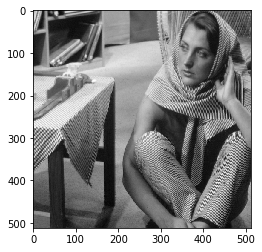

In [2]:
#Lecture of the image in gray scale and conversion in float64
img=np.float64(cv2.imread('barbara.png',0))/255.
shape = img.shape
print("Image dimension :",shape[0],"rows",shape[0],"columns")
plt.imshow(img,cmap = 'gray')

Image dimension : 512 rows 512 columns


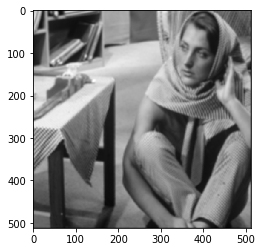

In [3]:
##  Application of convolution on the original image, with a PSF C which is a 5 × 5 matrix of ones
kernel = np.ones((5,5))/(5.**2)
img_conv = scipy.signal.convolve2d(img, kernel, mode='same')  
shape = img_conv.shape
print("Image dimension :",shape[0],"rows",shape[0],"columns")
plt.imshow(img_conv,cmap = 'gray')

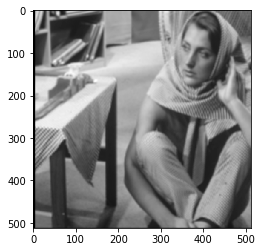

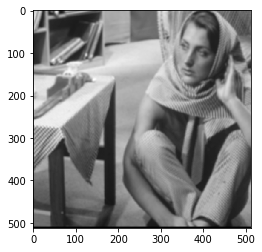

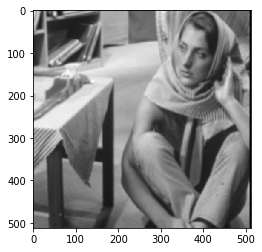

In [4]:
#### Generation of four translated images  
trans_dist = [(0,4),(-3,1),(1,-3)]

img_trans = []
index = 0 
for t in trans_dist:
    img_trans.append(scipy.ndimage.shift(img_conv, t))
    ShowImg(img_trans[index])
    index +=1

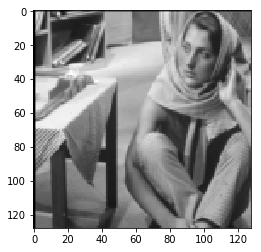

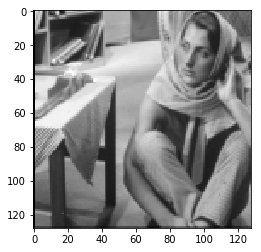

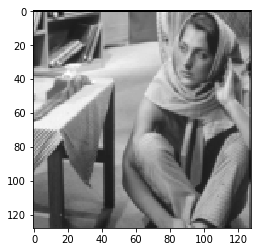

In [5]:
## Image down sampling

# initialize parameters
downs_fac = 4
img_downsamp = []
index = 0
# Perform down sampling in the 4 LR images
for im in img_trans:
    img_downsamp.append(im[:im.shape[0]:downs_fac, :im.shape[1]:downs_fac])
    ShowImg(img_downsamp[index])
    index +=1

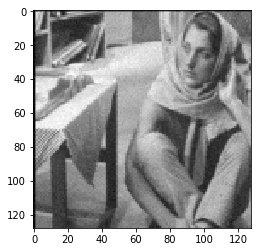

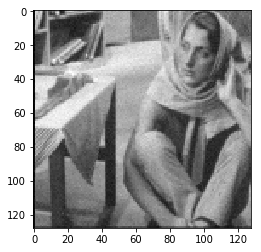

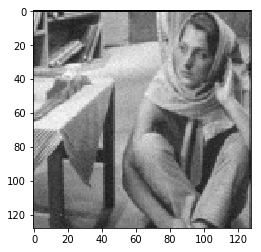

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]
C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


In [6]:
# Image noising

#Initialize parameters
noisy_img = []
sigma = 0.02 # variance of gaussian distribution
mu = 0. # mean of gaussian distribution
index =0
# Adding noise for the 4 LR images
for im in img_downsamp:
    noisy_img.append(im + np.random.normal(size=im.shape, scale=sigma, loc=mu))
    ShowImg(noisy_img[index])    
    index +=1
scipy.misc.imsave("LR_1.png",noisy_img[0])
scipy.misc.imsave("LR_2.png",noisy_img[1])
scipy.misc.imsave("LR_3.png",noisy_img[2])

the percentage of correct pixel is : 18.701171875 %


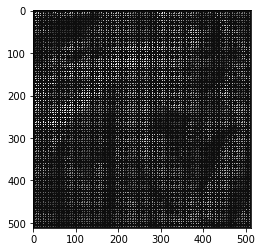

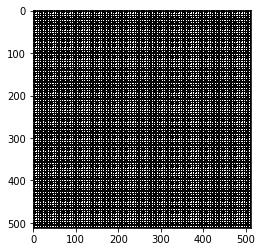

In [7]:
# Generation of low resolution images from original high resolution image, by convolution, translation and down sampling

M = np.zeros(shape=shape) # Binary mask

img_LR = np.zeros(shape=shape) # Low resolution images combination
# Construction of the mask and the masked image with the same size of the original image
i = 0
for x,y in trans_dist:
    row = np.arange(x,shape[0],downs_fac) if x>=0 else np.arange(0,shape[0]-x,downs_fac)
    col = np.arange(y,shape[1],downs_fac) if y>=0 else np.arange(0,shape[0]-y,downs_fac)
    j = (shape[0]-abs(x)+downs_fac-1) //downs_fac
    k = (shape[1]-abs(y)+downs_fac-1) //downs_fac
    for r in range(j):
        for c in range(k):
            img_LR[row[r], col[c]] += noisy_img[i][r,c]
            M[row[r], col[c]] = 1
    i += 1

# calculate the percentage of correct pixel 
mean_correct_pixel =  np.sum(M)/(shape[0]*shape[1])
print("the percentage of correct pixel is :", mean_correct_pixel *100,"%")
ShowImg(img_LR)
ShowImg(M)

## Super resolution : Inverse problem

### INPAINTING

#### Method 1 

iteration =  0 , Lambda =  0.05


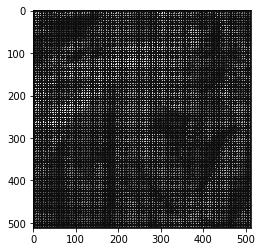

iteration =  250 , Lambda =  0.05


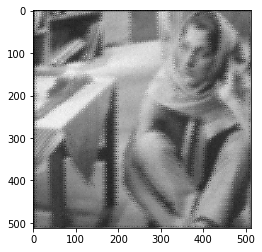

iteration =  0 , Lambda =  0.08333333333333334


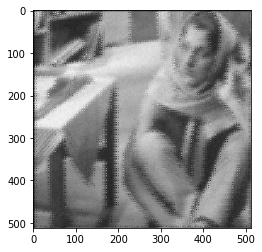

iteration =  250 , Lambda =  0.08333333333333334


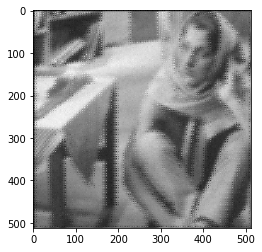

iteration =  0 , Lambda =  0.11666666666666667


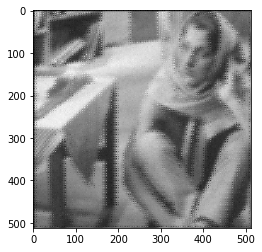

iteration =  250 , Lambda =  0.11666666666666667


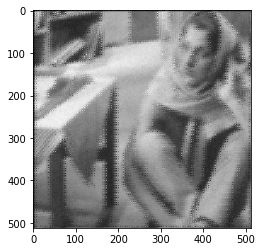

iteration =  0 , Lambda =  0.15


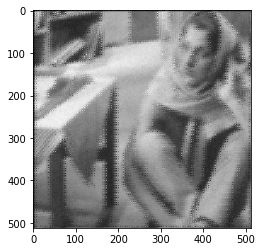

iteration =  250 , Lambda =  0.15


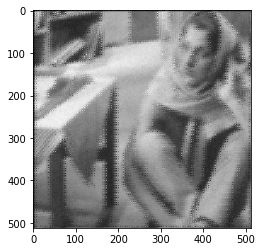

In [8]:
##Sobolev inpainting

# Operators
# Projection operator 
Pi = lambda f: (1-Omega)*f + (Omega)*y
# The gradient of the Sobolev energy E
Delta =  lambda f : div(grad(f))

# Parameters
y = img_LR
Omega = M
Lambdas = list(np.linspace(0.05,0.15,4))  #the gradient descent step size should satisfy: Lambda < 1/4
niter = 251
# Algorithm
E = [[] for i in range(len(Lambdas))]
f = y
index = 0 
SNRs = []
for Lambda in Lambdas:  
    for i in range(niter):
        E[index].append(LA.norm(grad(f)))
        f = Pi( f + Lambda*Delta(f) )
        if i%250==0: 
            print("iteration = ",i,", Lambda = ", Lambda)
            ShowImg(f)
    SNRs.append(snr(img,f))
    index +=1
        

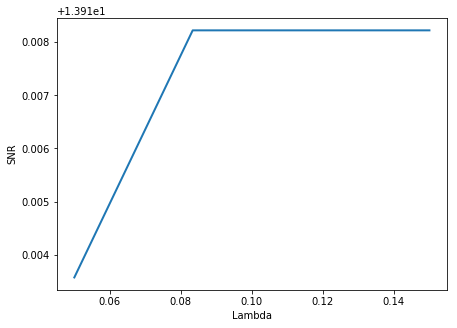

In [9]:
# Decay of the energy in terms of the iterations.
plt.figure(figsize=(7,5))
plt.plot(Lambdas,SNRs, linewidth=2)
plt.xlabel("Lambda")
plt.ylabel("SNR")
plt.show()

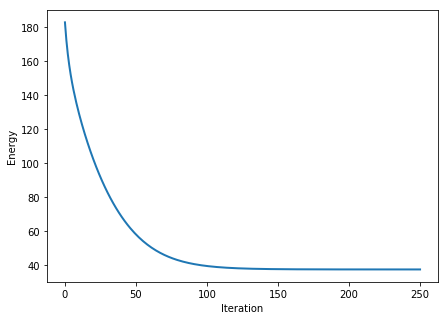

In [13]:
# Decay of the energy in terms of the iterations.
plt.figure(figsize=(7,5))
plt.plot(E[0], linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

iteration =  0 , Lambda =  0.08


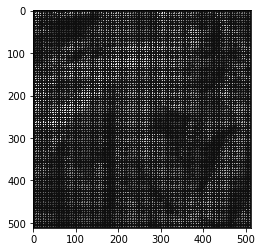

iteration =  20 , Lambda =  0.08


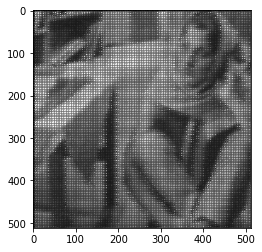

iteration =  40 , Lambda =  0.08


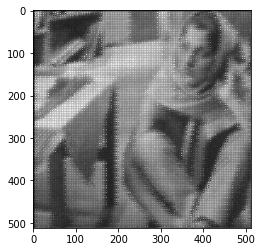

iteration =  60 , Lambda =  0.08


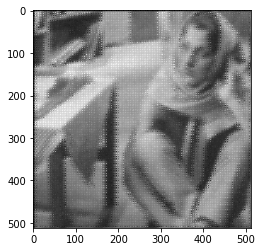

iteration =  80 , Lambda =  0.08


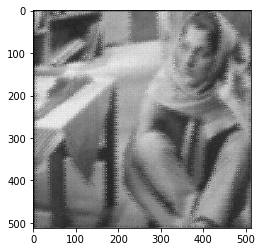

iteration =  100 , Lambda =  0.08


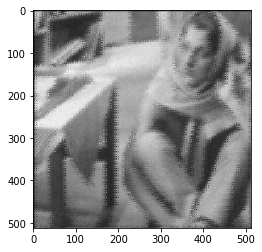

iteration =  120 , Lambda =  0.08


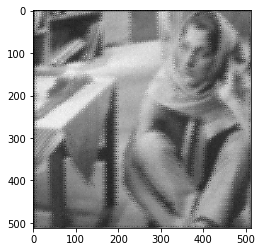

iteration =  140 , Lambda =  0.08


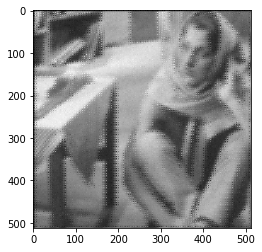

In [11]:
# Operators
# Projection operator 
Pi = lambda f: (1-Omega)*f + (Omega)*y
# The gradient of the Sobolev energy E
Delta =  lambda f : div(grad(f))

# Parameters
y = img_LR
Omega = M
Lambdas = list(np.linspace(0.05,0.2,6))
Lambda = 0.08#Lambdas[np.argmax(SNRs)] # the best Lambda  #the gradient descent step size should satisfy: Lambda < 1/4
niter = 151
# Algorithm
Esob = []
fsob = y
for i in range(niter):
    Esob.append(LA.norm(grad(fsob)))
    fsob = Pi( fsob + Lambda*Delta(fsob) )
    if i%150==0: 
        print("iteration = ",i,", Lambda = ", Lambda)
        ShowImg(fsob)


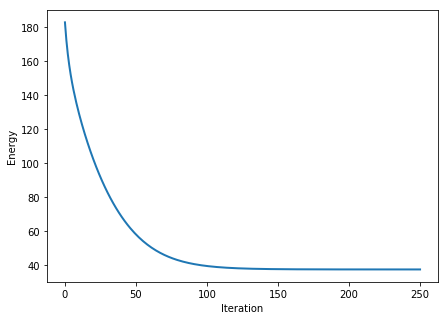

In [18]:
# Decay of the energy in terms of the iterations.
plt.figure(figsize=(7,5))
plt.plot(E[0], linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

#### Method 2 

iteration =  0 , epsilon =  0.1


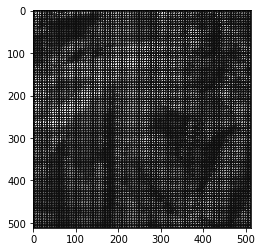

iteration =  200 , epsilon =  0.1


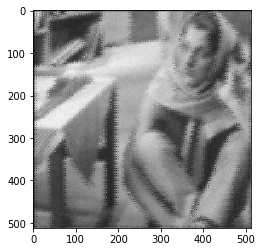

iteration =  0 , epsilon =  6.074999999999999


iteration =  200 , epsilon =  6.074999999999999


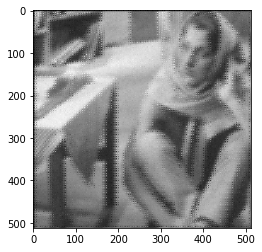

iteration =  0 , epsilon =  12.049999999999999


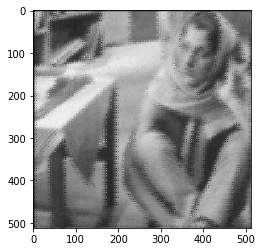

iteration =  200 , epsilon =  12.049999999999999


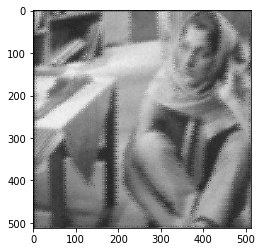

iteration =  0 , epsilon =  18.025


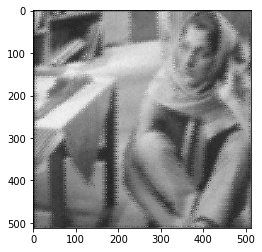

iteration =  200 , epsilon =  18.025


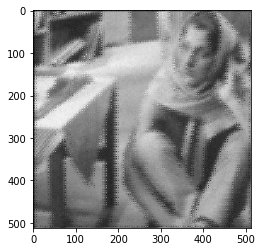

iteration =  0 , epsilon =  24.0


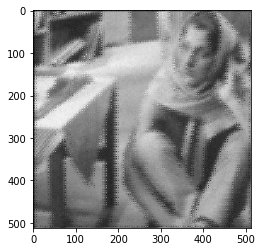

iteration =  200 , epsilon =  24.0


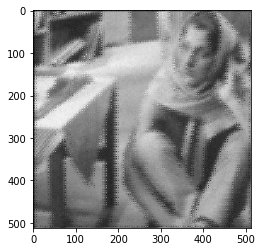

In [20]:
#Inpainting with TV-2 Regularization

# Normalization operator 
Amplitude = lambda u,epsilon : np.sqrt(np.sum(u*u,axis=2)+epsilon**2)
Neps = lambda u,epsilon : np.divide(u,(np.tile(Amplitude(u,epsilon), [2, 1, 1])).reshape(shape[0],shape[1],2))
# Gradient of J (smoothed TV norm)
G = lambda f : -div(Neps(grad(f),epsilon))

#Parameters 
#Regularization parameter
epsilons =list(np.linspace(0.1,24.,5))
#Step size
#tau = .9*epsilon/4

#Algorithm
niter = 201
J = [[] for i in range(len(epsilons))]
f = y
index = 0
SNRs = []
for epsilon in epsilons:
    for i in range(niter):
        J[index].append(np.sum(np.sum(Amplitude(grad(f),epsilon))))
        tau = .9*epsilon/4
        f = Pi( f - tau*G(f) )
        if i%200==0: 
            print("iteration = ",i,", epsilon = ", epsilon)
            ShowImg(f)
    SNRs.append(snr(img,f))
    index += 1
    

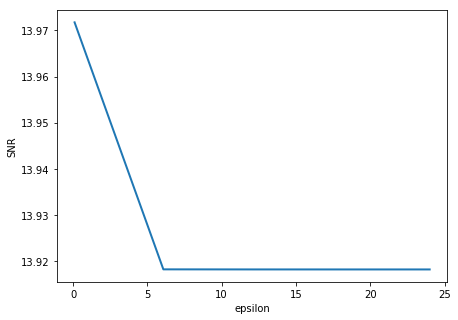

In [21]:
# Decay of the energy in terms of the iterations.
plt.figure(figsize=(7,5))
plt.plot(epsilons,SNRs, linewidth=2)
plt.xlabel("epsilon")
plt.ylabel("SNR")
plt.show()

iteration =  0 , epsilon =  0.1


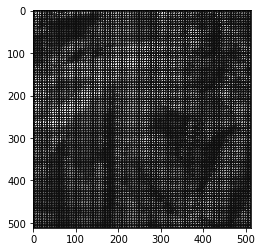

iteration =  20 , epsilon =  0.1


iteration =  40 , epsilon =  0.1


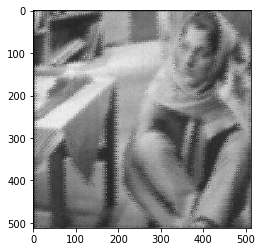

iteration =  60 , epsilon =  0.1


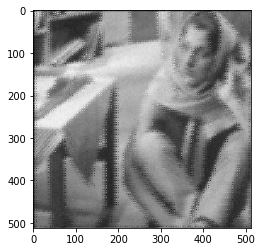

In [22]:
#Inpainting with TV-2 Regularization

# Normalization operator 
Amplitude = lambda u,epsilon : np.sqrt(np.sum(u*u,axis=2)+epsilon**2)
Neps = lambda u,epsilon : np.divide(u,(np.tile(Amplitude(u,epsilon), [2, 1, 1])).reshape(shape[0],shape[1],2))
# Gradient of J (smoothed TV norm)
G = lambda f : -div(Neps(grad(f),epsilon))

#Parameters 
#Regularization parameter
epsilon = 0.1 #best epsilon
#Step size
tau = .9*epsilon/4

#Algorithm
niter = 61
J = []
fTV = y
index = 0
for i in range(niter):
    J.append(np.sum(np.sum(Amplitude(grad(fTV),epsilon))))
    fTV = Pi( fTV - tau*G(fTV) )
    if i%20==0: 
        print("iteration = ",i,", epsilon = ", epsilon)
        ShowImg(fTV)

    

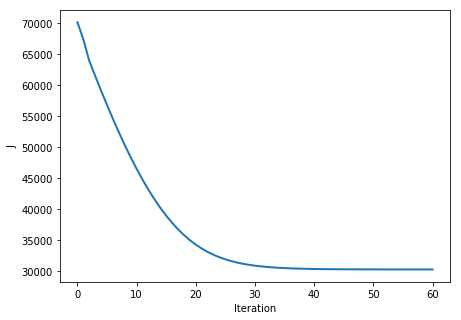

In [23]:
# Decay of the energy in terms of the iterations.
plt.figure(figsize=(7,5))
plt.plot(J, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("J")
plt.show()

## Deconvolution
Deconvolution corresponds to removing a blur from an image. We use here a Gaussian blur.

Text(0,0.5,'SNR')

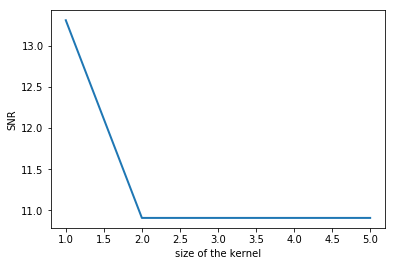

In [24]:
## Deconvolution with L2 Regularization
## Choice of the best kernel size to deconvolve with
SNRs = []
size = [1,2,3,4,5]
N= shape[0]
f=fTV

for s in size:
    b=np.ones((s,s))/s**2 # box blur kernel

    # fft
    F=np.fft.fft2(b,[N,N])
    F[np.abs(F)<1]=0.5
    hF=np.ones((N,N))/F
    
    yF = np.fft.fft2(f)

    Lambda = 0.0790
    fL2 = np.real( np.fft.ifft2( yF * hF / ( np.abs(hF)**2 + Lambda) ) )

    SNRs.append(snr(img,fL2))


plt.plot(size,SNRs,linewidth=2)
plt.xlabel("size of the kernel")
plt.ylabel("SNR")

In [22]:
## the best kernel size is given by
kernel_size = size[np.argmax(SNRs)]
kernel_size

1

SNR=13.95467229966413


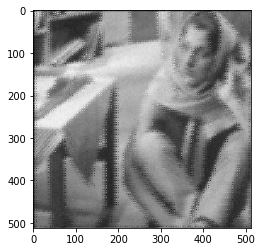

SNR=0.7828894940363483


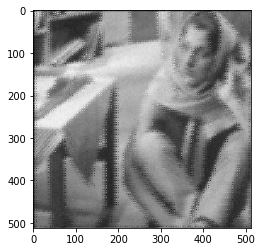

SNR=0.40171574622264117


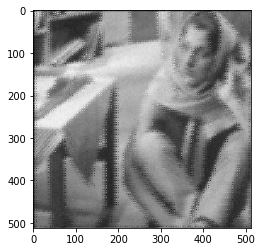

SNR=0.27018799057980414


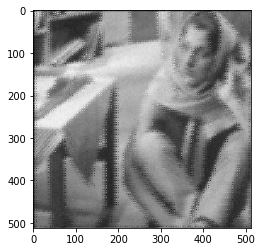

SNR=0.2035466457218379


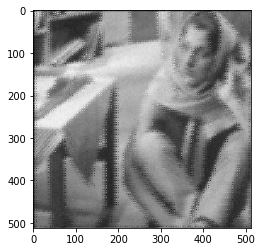

SNR=0.16327571676297545


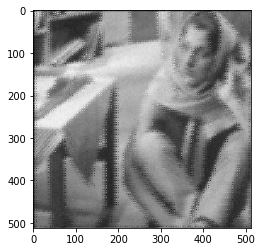

SNR=0.13630794877009456


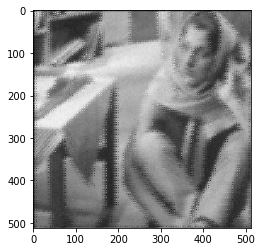

SNR=0.11698584202327238


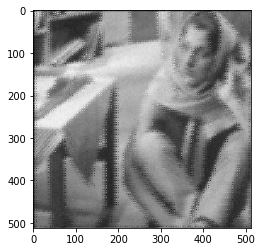

SNR=0.10246161323635268


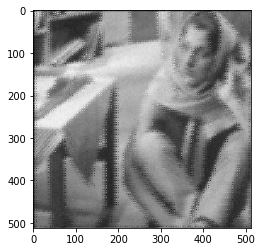

SNR=0.09114557453904434


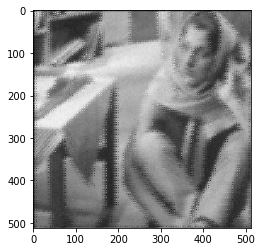

In [27]:
# Choice of the best regularization parameter
#parameters that model the impulse reponse
N= shape[0]
b=np.ones((1,1)) #kernel

# fft
F=np.fft.fft2(b,[N,N])
F[np.abs(F)<1]=0.5
hF=np.ones((N,N))/F
yF = np.fft.fft2(f)

Lambdas = list(np.linspace(2*1e-3, 90., 10)) #regularization parameters
err = []

for Lambda in Lambdas:
    fL2 = np.real( np.fft.ifft2( yF * hF / ( np.abs(hF)**2 + Lambda) ) )
    err.append(snr(img,fL2))
    print('SNR=' + str(snr(img,fL2)))
    ShowImg(fL2)
    

Text(0,0.5,'SNR')

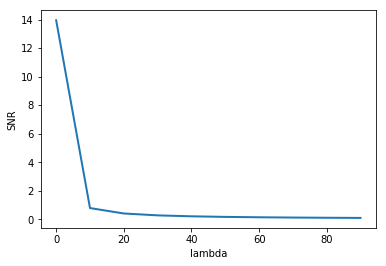

In [28]:
plt.plot(Lambdas,err,linewidth=2)
plt.xlabel("lambda")
plt.ylabel("SNR")

In [29]:
# the best regularization parameter is given by
reg_par = Lambdas[np.argmax(err)]
print("the best regularization parameter is of value :",reg_par, "it gives a SNR = ",  err[np.argmax(err)])

the best regularization parameter is of value : 0.002 it gives a SNR =  13.95467229966413
